In [ ]:
# Standard imports
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import Network as Network
import mnist_loader
import copy
import time

In [ ]:
class RobustNetwork(Network.Network):    
    
    def FeedBack(self, y, mode = 'BFA'):
        '''
            y = net.FeedBack(x)

            Runs the network backward, starting with y as input.

        '''
        y = np.array(y)  # Convert input to array, in case it's not
        
        self.lyr[-1].h_feedback = y # Set input layer

        # Loop over connections...
        if (mode == 'BFA'):
            for pre,post,W_feedback in zip(reversed(self.lyr[1:]), reversed(self.lyr[:-1]), reversed(self.W_feedback)):
                post.z_feedback = pre.h_feedback @ W_feedback
                post.h_feedback = post.sigma(post.z_feedback)
                    
        elif(mode == 'BDFA'):
            for post,W_BDFA in zip(reversed(self.lyr[:-1]), reversed(self.W_BDFA)):
                post.z_feedback = y @ W_BDFA
                post.h_feedback = post.sigma(post.z_feedback)
                
        # Return activity of output layer
        return self.lyr[0].h_feedback
    
    def BackProp(self, t, lrate=0.05, mode = 'BP'):
        '''
            net.BackProp(targets, lrate=0.05)
            
            Given the current network state and targets t, updates the connection
            weights and biases using the backpropagation algorithm.
            
            Inputs:
             t      an array of targets (number of samples must match the
                    network's output)
             lrate  learning rate
             decay  is the coefficient for weight/bias decay
        '''
        t = np.array(t)  # convert t to an array, in case it's not
        
        # Error gradient for top layer
        dEdz = self.TopGradient(t)
        top_gradient = dEdz
                
        # Loop down through the layers
        for i in range(self.n_layers-2, -1, -1):
            pre = self.lyr[i]

            # Gradient w.r.t. weights
            dEdW = pre.h.T @ dEdz

            # Project error gradient down to layer below.
            if i>0:
                if(mode == 'BP'):
                    dEdz = (dEdz @ self.W[i].T) * pre.sigma_z_p(pre.z)
                    
                elif(mode == 'FA'):
                    m = self.lyr[i+1].N
                    n = self.lyr[i].N
                    temp = np.random.normal(size=[m,n])/np.sqrt(n)*4.
                    dEdz = (dEdz @ temp) * pre.sigma_z_p(pre.z)
                    
                elif(mode == 'DFA'):
                    m = self.lyr[-1].N
                    n = self.lyr[i].N
                    temp = np.random.normal(size=[m,n])/np.sqrt(n)*4.
                    dEdz = (top_gradient @ temp) * pre.sigma_z_p(pre.z)     
                    
                elif(mode == 'BFA'):
                    dEdz = (dEdz @ self.W_feedback[i]) * pre.sigma_z_p(pre.z)
                    
                elif(mode == 'BDFA'):
                    dEdz = (top_gradient @ self.W_BDFA[i-1]) * pre.sigma_z_p(pre.z)
                    
                          
            # Update weights and biases
            self.W[i] -= lrate*dEdW
            

    def BackProp_FeedBack(self, x, y, lrate = 0.05, mode = 'BFA'):
                
        x = np.array(x)  # convert t to an array, in case it's not
        y = np.array(y)
        
        # Error gradient for top layer
        dEdz_feedback = self.TopGradient(x, mode = 'BFA')

        # Loop down through the layers
        if (mode == 'BFA'):
            for i in range(1,self.n_layers,1):
                pre = self.lyr[i]
                dEdW_feedback = pre.h_feedback.T @ dEdz_feedback

                # Project error gradient down to layer below.
                if i<self.n_layers-1:
                    dEdz_feedback = (dEdz_feedback @ self.W[i-1]) * pre.sigma_z_p(pre.z_feedback)

                self.W_feedback[i-1] -= lrate*dEdW_feedback

        elif(mode =='BDFA'):

            for i in range(self.n_layers-2):
                m = self.lyr[-1].N
                n = self.lyr[i+1].N
                temp = np.random.normal(size=[m,n])/np.sqrt(n)*4.
                self.W_BDFA[i] = temp
#                 loss_fn = 1 - Network.Logistic(self.lyr[i+1].z_feedback * self.lyr[i+1].h)
#                 dEdW_BDFA = loss_fn.T @ y
#                 self.W_BDFA[i] -= lrate*dEdW_BDFA.T
      
            
    def SGD(self, inputs, targets, lrate=0.05, epochs=1, batch_size=10, mode='BP'):
        '''
            progress = net.SGD(inputs, targets, lrate=0.05, epochs=1, decay=0, dropout=0)

            Performs Stochastic Gradient Descent on the network.
            Run through the dataset in batches 'epochs' number of times, incrementing the
            network weights after each batch. For each epoch, it
            shuffles the dataset.

            Inputs:
              inputs  is an array of input samples
              targets is a corresponding array of targets
              lrate   is the learning rate (try 0.001 to 5)
              epochs  is the number of times to go through the training data
              decay   is the decay coefficient for the weights and biases
              dropout is the dropout probability
              
            Outputs:
              progress is an (expochs)x2 array with epoch in the first column, and 
                      cost in the second column
        '''

        start = time.time()

        for i in range(self.n_layers-2):
            n = self.lyr[-1].N
            m = self.lyr[i+1].N
            temp = np.random.normal(size=[n,m])/np.sqrt(n)*4.
            self.W_BDFA.append(temp)

        
        loss_history = []
        for k in range(epochs):
            batches = Network.MakeBatches(inputs, targets, batch_size=batch_size, shuffle=True)
            for mini_batch in batches:
                self.FeedForward(mini_batch[0])
                    
                self.BackProp(mini_batch[1], lrate=lrate, mode=mode)

                if (mode in ['BFA', 'BDFA']):
                    self.FeedBack(mini_batch[1], mode=mode)
                    
                if (mode in ['BFA', 'BDFA']):
                    
                    self.BackProp_FeedBack(mini_batch[0], mini_batch[1], lrate=lrate, mode=mode)

            loss_history.append([k, self.Evaluate(inputs, targets)])
            print('Epoch '+str(loss_history[-1][0])+': Cost = '+str(loss_history[-1][1]))

        end = time.time()
        print('Running Time: {}s'.format(end - start))
        return np.array(loss_history)


# Create and Train Network

## Classification

note:
1. top gradient function
2. print epochs

In [ ]:
# Read in MNIST samples
train, validate, test = mnist_loader.load_data_wrapper()
train_in = np.array(train[0])
train_out = np.array(train[1])
test_in = np.array(test[0])
test_out = np.array(test[1])

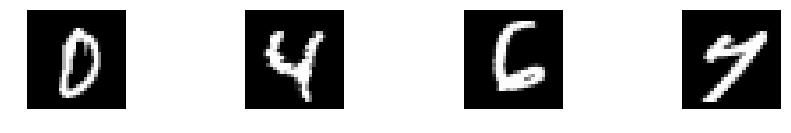

In [ ]:
# Display some sample digit images
plt.figure(figsize=[15,4])
n_digits = 4
for n in range(n_digits):
    idx = np.random.randint(10000)
    plt.subplot(2,n_digits,n+1)
    plt.imshow(np.reshape(train_in[idx], [28,28]), cmap='gray'); plt.axis('off');

### BP

In [ ]:
net_BP = RobustNetwork(cost='categorical-cross-entropy')

net_BP.AddLayer(Network.Layer(784))
net_BP.AddLayer(Network.Layer(400, act='tanh'))
net_BP.AddLayer(Network.Layer(10, act='softmax'))

# Train the network
#progress = net_BP.SGD(train_in, train_out, epochs=10, lrate=0.01, batch_size=128, mode='BP')
#progress = net_BP.SGD(train_in, train_out, epochs=300, lrate=0.0001, batch_size=128, mode='BFA')
progress = net_BP.SGD(train_in, train_out, epochs=300, lrate=0.005, batch_size=128, mode='BP')

# Evaluate the cost 
print('Training cost = '+str(net_BP.Evaluate(train_in, train_out)))

# Evaluate the accuracy
train_ac = Network.ClassificationAccuracy(net_BP.FeedForward(train[0]), train[1])
print('Training Accuracy = '+str(train_ac*100)+'%')

test_ac = Network.ClassificationAccuracy(net_BP.FeedForward(test[0]), test[1])
print('Testing Accuracy = '+str(test_ac*100)+'%')


Epoch 0: Cost = 0.7709425973292542
Epoch 1: Cost = 0.5616270033878585
Epoch 2: Cost = 0.48269786790033803
Epoch 3: Cost = 0.4373493766709634
Epoch 4: Cost = 0.40737312807409837
Epoch 5: Cost = 0.3839598991489312
Epoch 6: Cost = 0.36605052031364227
Epoch 7: Cost = 0.3512503403773775
Epoch 8: Cost = 0.3384351305034514
Epoch 9: Cost = 0.32758087606951425
Epoch 10: Cost = 0.31777178404992873
Epoch 11: Cost = 0.3095275973088997
Epoch 12: Cost = 0.3016787189670877
Epoch 13: Cost = 0.2944202794180027
Epoch 14: Cost = 0.2878229831387798
Epoch 15: Cost = 0.2819327095854086
Epoch 16: Cost = 0.2764998492502959
Epoch 17: Cost = 0.2711593746822866
Epoch 18: Cost = 0.26631967295344827
Epoch 19: Cost = 0.2617359488603547
Epoch 20: Cost = 0.2575216427197988
Epoch 21: Cost = 0.2533628642803349
Epoch 22: Cost = 0.24942236027864367
Epoch 23: Cost = 0.24582985833052776
Epoch 24: Cost = 0.24239657503399437
Epoch 25: Cost = 0.238956040805173
Epoch 26: Cost = 0.23561464063078863
Epoch 27: Cost = 0.2325982582

Epoch 220: Cost = 0.0736149241354045
Epoch 221: Cost = 0.07328894343933971
Epoch 222: Cost = 0.07302316786241601
Epoch 223: Cost = 0.07275539739699853
Epoch 224: Cost = 0.07245726298618203
Epoch 225: Cost = 0.07219108639914076
Epoch 226: Cost = 0.07193177793320553
Epoch 227: Cost = 0.07170173489733625
Epoch 228: Cost = 0.07135374225046123
Epoch 229: Cost = 0.07110085995304428
Epoch 230: Cost = 0.0708664787386619
Epoch 231: Cost = 0.07055851707448886
Epoch 232: Cost = 0.07030414150608434
Epoch 233: Cost = 0.07005294968760109
Epoch 234: Cost = 0.06979278955605046
Epoch 235: Cost = 0.06949650923356722
Epoch 236: Cost = 0.06929502134732322
Epoch 237: Cost = 0.06898739510049898
Epoch 238: Cost = 0.06873014333312678
Epoch 239: Cost = 0.06851544477024225
Epoch 240: Cost = 0.06827103160485887
Epoch 241: Cost = 0.06800736471768919
Epoch 242: Cost = 0.06773710289485513
Epoch 243: Cost = 0.0674964959817002
Epoch 244: Cost = 0.06724187430149707
Epoch 245: Cost = 0.06700904053533205
Epoch 246: Cost

### FA

In [ ]:
net_FA = RobustNetwork(cost='categorical-cross-entropy')

net_FA.AddLayer(Network.Layer(784))
net_FA.AddLayer(Network.Layer(400, act='tanh'))
net_FA.AddLayer(Network.Layer(10, act='softmax'))

# Train the network
#progress = net_FA.SGD(train_in, train_out, epochs=10, lrate=0.01, batch_size=128, mode='FA')
#progress = net_FA.SGD(train_in, train_out, epochs=300, lrate=0.0001, batch_size=128, mode='BFA')
progress = net_FA.SGD(train_in, train_out, epochs=300, lrate=0.005, batch_size=128, mode='BFA')

# Evaluate the cost 
print('Training cost = '+str(net_FA.Evaluate(train_in, train_out)))

# Evaluate the accuracy
train_ac = Network.ClassificationAccuracy(net_FA.FeedForward(train[0]), train[1])
print('Training Accuracy = '+str(train_ac*100)+'%')

test_ac = Network.ClassificationAccuracy(net_FA.FeedForward(test[0]), test[1])
print('Testing Accuracy = '+str(test_ac*100)+'%')


Epoch 0: Cost = 1.4184576238804345
Epoch 1: Cost = 0.9486614942098673
Epoch 2: Cost = 0.764245182367464
Epoch 3: Cost = 0.6661548994539994
Epoch 4: Cost = 0.6036476997177393
Epoch 5: Cost = 0.5594158164669435
Epoch 6: Cost = 0.5258823969848762
Epoch 7: Cost = 0.49909195501593173
Epoch 8: Cost = 0.47723194503344174
Epoch 9: Cost = 0.45883803848123905
Epoch 10: Cost = 0.4431027683688326
Epoch 11: Cost = 0.4295297485254799
Epoch 12: Cost = 0.4172152995437293
Epoch 13: Cost = 0.40636137576087583
Epoch 14: Cost = 0.39654533008792237
Epoch 15: Cost = 0.3875793550628611
Epoch 16: Cost = 0.37941745804198834
Epoch 17: Cost = 0.37185915499234784
Epoch 18: Cost = 0.36494135990533466
Epoch 19: Cost = 0.3582986752705853
Epoch 20: Cost = 0.3522792758218033
Epoch 21: Cost = 0.34641573823630284
Epoch 22: Cost = 0.3409559747087249
Epoch 23: Cost = 0.33580277101819744
Epoch 24: Cost = 0.3309057957028085
Epoch 25: Cost = 0.32617301801050436
Epoch 26: Cost = 0.32171250565916487
Epoch 27: Cost = 0.31761196

Epoch 221: Cost = 0.10265837739970242
Epoch 222: Cost = 0.10227419431307479
Epoch 223: Cost = 0.10194642574205545
Epoch 224: Cost = 0.10155905207932121
Epoch 225: Cost = 0.10120858943799454
Epoch 226: Cost = 0.1009017045405617
Epoch 227: Cost = 0.10052869003310634
Epoch 228: Cost = 0.1002532964424507
Epoch 229: Cost = 0.09983843146833073
Epoch 230: Cost = 0.09950833170773495
Epoch 231: Cost = 0.09915691015805875
Epoch 232: Cost = 0.09881338108739444
Epoch 233: Cost = 0.09848274802249343
Epoch 234: Cost = 0.0981600388082057
Epoch 235: Cost = 0.09785087824754123
Epoch 236: Cost = 0.09750354481024964
Epoch 237: Cost = 0.09717742074226975
Epoch 238: Cost = 0.09685950826843309
Epoch 239: Cost = 0.0965420345825892
Epoch 240: Cost = 0.09622255584110583
Epoch 241: Cost = 0.09591486201624315
Epoch 242: Cost = 0.0955877190678908
Epoch 243: Cost = 0.09525461992531566
Epoch 244: Cost = 0.09499085475797811
Epoch 245: Cost = 0.09462459729121898
Epoch 246: Cost = 0.09431151959945654
Epoch 247: Cost =

### DFA

In [ ]:
net_DFA = RobustNetwork(cost='categorical-cross-entropy')

net_DFA.AddLayer(Network.Layer(784))
net_DFA.AddLayer(Network.Layer(400, act='tanh'))
net_DFA.AddLayer(Network.Layer(10, act='softmax'))

# Train the network
progress = net_DFA.SGD(train_in, train_out, epochs=10, lrate=0.01, batch_size=128, mode='DFA')
#progress = net_DFA.SGD(train_in, train_out, epochs=300, lrate=0.0001, batch_size=128, mode='BFA')

# Evaluate the cost 
print('Training cost = '+str(net_DFA.Evaluate(train_in, train_out)))

# Evaluate the accuracy
train_ac = Network.ClassificationAccuracy(net_DFA.FeedForward(train[0]), train[1])
print('Training Accuracy = '+str(train_ac*100)+'%')

test_ac = Network.ClassificationAccuracy(net_DFA.FeedForward(test[0]), test[1])
print('Testing Accuracy = '+str(test_ac*100)+'%')


Epoch 0: Cost = 1.0620026826458617
Epoch 1: Cost = 0.7525540712639381
Epoch 2: Cost = 0.63761487120306
Epoch 3: Cost = 0.5733833220562453
Epoch 4: Cost = 0.5316138717918563
Epoch 5: Cost = 0.5005423107617768
Epoch 6: Cost = 0.4784072556431297
Epoch 7: Cost = 0.4602871902900395
Epoch 8: Cost = 0.44556127919083455
Epoch 9: Cost = 0.43293124665284066
Running Time: 31.435232639312744s
Training cost = 0.43293124665284066
Training Accuracy = 86.876%
Testing Accuracy = 87.66000000000001%


### BFA

Epoch 0: Cost = 1.3575126911509174
Epoch 1: Cost = 0.9227608337874006
Epoch 2: Cost = 0.7566251605460006
Epoch 3: Cost = 0.6645329683637619
Epoch 4: Cost = 0.6043955296375176
Epoch 5: Cost = 0.5608787416661196
Epoch 6: Cost = 0.5274632410509575
Epoch 7: Cost = 0.5007512526064265
Epoch 8: Cost = 0.4787048383982863
Epoch 9: Cost = 0.4599143430249648
Epoch 10: Cost = 0.443601325427607
Epoch 11: Cost = 0.4293833035221495
Epoch 12: Cost = 0.4167412651625339
Epoch 13: Cost = 0.4053698245466645
Epoch 14: Cost = 0.3952023779966924
Epoch 15: Cost = 0.3860143038240839
Epoch 16: Cost = 0.37720872239834285
Epoch 17: Cost = 0.3693901644858035
Epoch 18: Cost = 0.36201046006868914
Epoch 19: Cost = 0.35506396935710277
Epoch 20: Cost = 0.34863451103632287
Epoch 21: Cost = 0.3426091941088395
Epoch 22: Cost = 0.33703888541314414
Epoch 23: Cost = 0.33160418519133783
Epoch 24: Cost = 0.32661484559809867
Epoch 25: Cost = 0.3216838981730526
Epoch 26: Cost = 0.317030836263474
Epoch 27: Cost = 0.31282674974737

Epoch 221: Cost = 0.10317762391375031
Epoch 222: Cost = 0.10281017469654877
Epoch 223: Cost = 0.1024375514349765
Epoch 224: Cost = 0.10209317298262342
Epoch 225: Cost = 0.10176648482627049
Epoch 226: Cost = 0.10137928351605589
Epoch 227: Cost = 0.10101632837413427
Epoch 228: Cost = 0.10070002903669918
Epoch 229: Cost = 0.10034010832922964
Epoch 230: Cost = 0.10003666144548454
Epoch 231: Cost = 0.09971380700836356
Epoch 232: Cost = 0.09932474787971278
Epoch 233: Cost = 0.0990106597034538
Epoch 234: Cost = 0.09863392343813077
Epoch 235: Cost = 0.098316466524256
Epoch 236: Cost = 0.09797604965276263
Epoch 237: Cost = 0.09765754631771961
Epoch 238: Cost = 0.09732462949823664
Epoch 239: Cost = 0.09700187336287255
Epoch 240: Cost = 0.09671229710388093
Epoch 241: Cost = 0.09635383489008337
Epoch 242: Cost = 0.09604539414038336
Epoch 243: Cost = 0.09573015296066474
Epoch 244: Cost = 0.09542433287448406
Epoch 245: Cost = 0.09510685990409772
Epoch 246: Cost = 0.09480418533975267
Epoch 247: Cost 

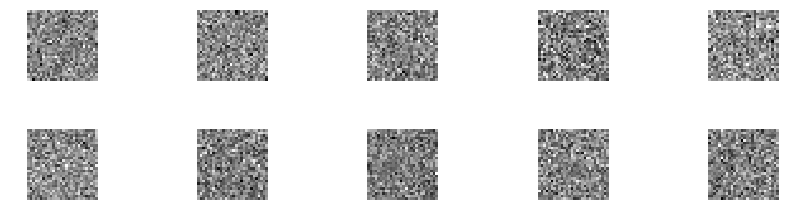

In [ ]:
net_BFA = RobustNetwork(cost='categorical-cross-entropy')

net_BFA.AddLayer(Network.Layer(784))
net_BFA.AddLayer(Network.Layer(400, act='tanh'))
net_BFA.AddLayer(Network.Layer(10, act='softmax'))

# Train the network
#progress = net_BFA.SGD(train_in, train_out, epochs=10, lrate=0.01, batch_size=128, mode='BFA')
progress = net_BFA.SGD(train_in, train_out, epochs=300, lrate=0.005, batch_size=128, mode='BFA')

# Evaluate the cost 
print('Training cost = '+str(net_BFA.Evaluate(train_in, train_out)))

# Evaluate the accuracy
train_ac = Network.ClassificationAccuracy(net_BFA.FeedForward(train[0]), train[1])
print('Training Accuracy = '+str(train_ac*100)+'%')

test_ac = Network.ClassificationAccuracy(net_BFA.FeedForward(test[0]), test[1])
print('Testing Accuracy = '+str(test_ac*100)+'%')

# Generate feature maps learned by feedback features
plt.figure(figsize=[15,4])
n_digits = 10
for n in range(n_digits):
    y = np.zeros(10)
    y[n] = 1
    reconstruct = net_BFA.FeedBack(y)
    plt.subplot(2,n_digits,2*n+1)
    plt.imshow(np.reshape(reconstruct, [28,28]), cmap='gray'); plt.axis('off');


### BDFA

Epoch 0: Cost = 0.5396003182851936
Epoch 1: Cost = 0.4451623857190186
Epoch 2: Cost = 0.40092786144225667
Epoch 3: Cost = 0.37303456625561693
Epoch 4: Cost = 0.35643598341483484
Epoch 5: Cost = 0.34116671218769273
Epoch 6: Cost = 0.3293404031559976
Epoch 7: Cost = 0.3203388561127718
Epoch 8: Cost = 0.31289913970343497
Epoch 9: Cost = 0.3050864124400281
Running Time: 28.657159328460693s
Training cost = 0.3050864124400281
Training Accuracy = 91.056%
Testing Accuracy = 91.3%


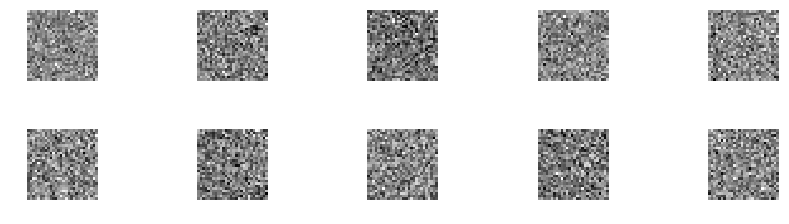

In [ ]:
net_BDFA = RobustNetwork(cost='categorical-cross-entropy')

net_BDFA.AddLayer(Network.Layer(784))
net_BDFA.AddLayer(Network.Layer(400, act='tanh'))
net_BDFA.AddLayer(Network.Layer(10, act='softmax'))

# Train the network
progress = net_BDFA.SGD(train_in, train_out, epochs=10, lrate=0.05, batch_size=128, mode='BDFA')
#progress = net_BDFA.SGD(train_in, train_out, epochs=300, lrate=0.005, batch_size=128, mode='BDFA')

# Evaluate the cost 
print('Training cost = '+str(net_BDFA.Evaluate(train_in, train_out)))

# Evaluate the accuracy
train_ac = Network.ClassificationAccuracy(net_BDFA.FeedForward(train[0]), train[1])
print('Training Accuracy = '+str(train_ac*100)+'%')

test_ac = Network.ClassificationAccuracy(net_BDFA.FeedForward(test[0]), test[1])
print('Testing Accuracy = '+str(test_ac*100)+'%')

# Generate feature maps learned by feedback features
plt.figure(figsize=[15,4])
n_digits = 10
for n in range(n_digits):
    y = np.zeros(10)
    y[n] = 1
    reconstruct = net_BDFA.FeedBack(y)
    plt.subplot(2,n_digits,2*n+1)
    plt.imshow(np.reshape(reconstruct, [28,28]), cmap='gray'); plt.axis('off');


## Images -> Images

In [ ]:
train_img, validate_img, test_img = mnist_loader.load_data_wrapper()
train_in_img = np.array(train_img[0][:10000])

In [ ]:
# Cosine Proximity
def CosineProximity(y, t):
    '''
        C = CosineProximity(y, t)
        
        Evaluates the average cosine proximity for the batch.
        
        Inputs:
          y is a batch of samples, with samples stored in rows
          t is a batch of targets
          
        Output:
          C is the average cosine proximity (cost)
    '''
    C = -np.sum(y*t, axis=1)
    C /= np.linalg.norm(y, axis=1)
    C /= np.linalg.norm(t, axis=1)
    return np.sum(C) / Network.NSamples(y)


# CosineProximity_p
def CosineProximity_p(y, t):
    '''
        dCdy = CosineProximity_p(y, t)
        
        Computes the gradient of the cosine proximity cost function.
        
        Inputs:
          y is a batch of samples, with samples stored in rows
          t is a batch of targets
          
        Output:
          dCdy is an array the same size as y, holding the derivative
               of the cost with respect to each element in y
    '''
    
    # ***** YOUR CODE HERE *****
    y_norm = np.reshape(np.linalg.norm(y, axis=1),(-1,1))
    t_norm = np.reshape(np.linalg.norm(t, axis=1),(-1,1))
    
    part1= -t/(y_norm*t_norm)
 
    yt_dot = np.reshape(np.sum(y*t, axis=1),(-1,1))
    part2 = (yt_dot*y)/(t_norm*pow(y_norm,3))

    dCdy = part1 + part2
    return dCdy

In [ ]:
net_image = RobustNetwork()

net_image.AddLayer(Network.Layer(784))
net_image.AddLayer(Network.Layer(50, act='logistic'))
net_image.AddLayer(Network.Layer(784, act='identity'))
net_image.cost = CosineProximity
net_image.cost_p = CosineProximity_p

In [ ]:
# Train the network
progress = net_image.SGD(train_in_img, train_in_img, epochs=60, lrate=1., batch_size=30, mode='BP')

# Evaluate the cost 
print('Training cost = '+str(net_image.Evaluate(train_in_img, train_in_img)))

Epoch 0: Cost = -0.7469066392996588
Epoch 1: Cost = -0.8037717210953429
Epoch 2: Cost = -0.8327964016824968
Epoch 3: Cost = -0.850860685631257
Epoch 4: Cost = -0.8622076192578741
Epoch 5: Cost = -0.8714629153032154
Epoch 6: Cost = -0.8758333358039284
Epoch 7: Cost = -0.8840026319609217
Epoch 8: Cost = -0.8882251795416516
Epoch 9: Cost = -0.8935604879732127
Epoch 10: Cost = -0.8966952330392465
Epoch 11: Cost = -0.9001009417221801
Epoch 12: Cost = -0.9013671892717362
Epoch 13: Cost = -0.9044763358018981
Epoch 14: Cost = -0.9068759487652313
Epoch 15: Cost = -0.90553437689477
Epoch 16: Cost = -0.9101446429350454
Epoch 17: Cost = -0.9118651272090729
Epoch 18: Cost = -0.9137737954089351
Epoch 19: Cost = -0.9137341909528146
Epoch 20: Cost = -0.9153648007854799
Epoch 21: Cost = -0.9144569523884786
Epoch 22: Cost = -0.9126577869084836
Epoch 23: Cost = -0.9146710633100665
Epoch 24: Cost = -0.9178086641274249
Epoch 25: Cost = -0.9197128281371217
Epoch 26: Cost = -0.9200073836185855
Epoch 27: Cost

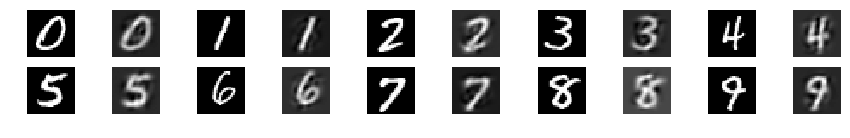

In [ ]:
# Display some sample digit images
plt.figure(figsize=[15,4])
n_digits = 10
idx_list = [7181,4585,4278,9829,6653,6274,1706,683,2378,7742]
for n,idx in zip(range(n_digits),idx_list):
    plt.subplot(4,n_digits,2*n+1)
    plt.imshow(np.reshape(train_in_img[idx], [28,28]), cmap='gray'); plt.axis('off');
    
    reconstruct = net_image.FeedForward(train_in_img[idx])
    plt.subplot(4,n_digits,2*(n+1))
    plt.imshow(np.reshape(reconstruct, [28,28]), cmap='gray'); plt.axis('off');


In [ ]:
net_image2 = RobustNetwork()

net_image2.AddLayer(Network.Layer(784))
net_image2.AddLayer(Network.Layer(50, act='logistic'))
net_image2.AddLayer(Network.Layer(784, act='identity'))
net_image2.cost = CosineProximity
net_image2.cost_p = CosineProximity_p

In [ ]:
# Train the network
progress = net_image2.SGD(train_in_img, train_in_img, epochs=30, lrate=1, batch_size=30, mode='BFA')

# Evaluate the cost 
print('Training cost = '+str(net_image2.Evaluate(train_in_img, train_in_img)))

Epoch 0: Cost = -0.6947601993730532
Epoch 1: Cost = -0.7496054217112241
Epoch 2: Cost = -0.7817718396272517
Epoch 3: Cost = -0.8042450801626962
Epoch 4: Cost = -0.8189293873781216
Epoch 5: Cost = -0.8311922937815823
Epoch 6: Cost = -0.8396592650762861
Epoch 7: Cost = -0.8462749116532459
Epoch 8: Cost = -0.8504648782050043
Epoch 9: Cost = -0.8528973806835058
Epoch 10: Cost = -0.8557455486205614
Epoch 11: Cost = -0.8579028503657852
Epoch 12: Cost = -0.858059722640683
Epoch 13: Cost = -0.85965578986832
Epoch 14: Cost = -0.8601610626607963
Epoch 15: Cost = -0.8599485621708678
Epoch 16: Cost = -0.8613881822949059
Epoch 17: Cost = -0.8607035850724627
Epoch 18: Cost = -0.8616935404854692
Epoch 19: Cost = -0.8614263408180526
Epoch 20: Cost = -0.8618616361729837
Epoch 21: Cost = -0.8620256807779986
Epoch 22: Cost = -0.8628428201809621
Epoch 23: Cost = -0.862152551388344
Epoch 24: Cost = -0.8610873251950502
Epoch 25: Cost = -0.8613043760733963
Epoch 26: Cost = -0.8598710379872009
Epoch 27: Cost 

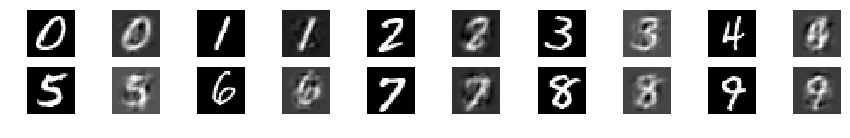

In [ ]:
# Display some sample digit images
plt.figure(figsize=[15,4])
n_digits = 10
idx_list = [7181,4585,4278,9829,6653,6274,1706,683,2378,7742]
for n,idx in zip(range(n_digits),idx_list):
    plt.subplot(4,n_digits,2*n+1)
    plt.imshow(np.reshape(train_in_img[idx], [28,28]), cmap='gray'); plt.axis('off');
    
    reconstruct = net_image2.FeedForward(train_in_img[idx])
    plt.subplot(4,n_digits,2*(n+1))
    plt.imshow(np.reshape(reconstruct, [28,28]), cmap='gray'); plt.axis('off');


## regression

In [ ]:
def GenerateDatasets(n):
    # 1D -> 1D (line mapping)
    n_input = 1
    n_output = 1
    noise = 0.5

    #np.random.seed(452)
    a = np.random.rand()/2.
    m = np.random.rand() + 0.5
    b = np.random.rand()-0.5

    def myfunc(x):
        return a*x**2 + m*x + b

    # Create a training dataset
    n_samples = n
    training_output = []
    training_input = []
    xv = np.linspace(-1, 1, n_samples)
    for idx in range(n_samples):
        #x = np.random.rand()*2. - 1.
        x = xv[idx]
        t = myfunc(x) + np.random.normal(scale=noise)
        training_input.append(np.array([x]))
        training_output.append(np.array([t]))

    # Create a testing dataset
    test_input = []
    test_output = []
    n_test_samples = 300
    xv = np.linspace(-1, 1, n_test_samples)
    for idx in range(n_test_samples):
        #x = np.random.rand()*2. - 1.
        x = xv[idx] #+ np.random.normal(scale=0.1)
        t = myfunc(x) + np.random.normal(scale=noise)
        test_input.append(np.array([x]))
        test_output.append(np.array([t]))


    train = [np.array(training_input), np.array(training_output)]
    test = [np.array(test_input), np.array(test_output)]
    
    return train, test

In [ ]:
# Generate the training and testing datasets
P = 5
train, test = GenerateDatasets(P)


### BP

In [ ]:
net_reg_BP = RobustNetwork(cost='MSE')
net_reg_BP.AddLayer(Network.Layer(1))
net_reg_BP.AddLayer(Network.Layer(10, act='arctan'))
net_reg_BP.AddLayer(Network.Layer(1, act='identity'))

# Train the network
progress = net_reg_BP.SGD(train[0], train[1], epochs=5000, lrate=1., batch_size=10, mode='BP')

# Evaluate the cost 
print('Training cost = '+str(net_reg_BP.Evaluate(train[0], train[1])))
print('    Test cost = '+str(net_reg_BP.Evaluate(test[0], test[1])))

Training cost = 0.01862421859254092
    Test cost = 0.5156461307451231


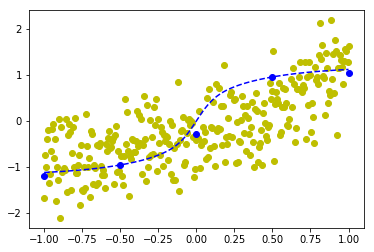

In [ ]:
plt.plot(test[0],test[1],'yo')
plt.plot(train[0],train[1],'bo')

s = np.linspace(min(min(train[0]),min(test[0])),
                max(max(train[0]),max(test[0])), 200)

# original_net
reg_y = net_reg_BP.FeedForward(np.array([s]).T)
plt.plot(s,reg_y,'b--')


### FA

Training cost = 0.01862421859254092
    Test cost = 0.6008451600271174


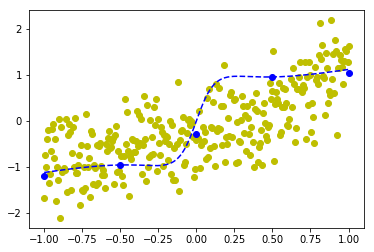

In [ ]:
net_reg_FA = RobustNetwork(cost='MSE')
net_reg_FA.AddLayer(Network.Layer(1))
net_reg_FA.AddLayer(Network.Layer(10, act='arctan'))
net_reg_FA.AddLayer(Network.Layer(1, act='identity'))

# Train the network
progress = net_reg_FA.SGD(train[0], train[1], epochs=5000, lrate=1., batch_size=10, mode='FA')

# Evaluate the cost 
print('Training cost = '+str(net_reg_FA.Evaluate(train[0], train[1])))
print('    Test cost = '+str(net_reg_FA.Evaluate(test[0], test[1])))

plt.plot(test[0],test[1],'yo')
plt.plot(train[0],train[1],'bo')

s = np.linspace(min(min(train[0]),min(test[0])),
                max(max(train[0]),max(test[0])), 200)

# original_net
reg_y = net_reg_FA.FeedForward(np.array([s]).T)
plt.plot(s,reg_y,'b--')


### DFA

Training cost = 0.23022058320070266
    Test cost = 0.49545055196430154


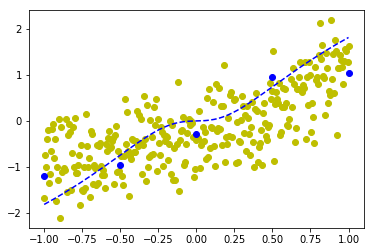

In [ ]:
net_reg_DFA = RobustNetwork(cost='MSE')
net_reg_DFA.AddLayer(Network.Layer(1))
net_reg_DFA.AddLayer(Network.Layer(10, act='arctan'))
net_reg_DFA.AddLayer(Network.Layer(1, act='identity'))

# Train the network
progress = net_reg_FA.SGD(train[0], train[1], epochs=5000, lrate=1., batch_size=10, mode='DFA')

# Evaluate the cost 
print('Training cost = '+str(net_reg_DFA.Evaluate(train[0], train[1])))
print('    Test cost = '+str(net_reg_DFA.Evaluate(test[0], test[1])))

plt.plot(test[0],test[1],'yo')
plt.plot(train[0],train[1],'bo')

s = np.linspace(min(min(train[0]),min(test[0])),
                max(max(train[0]),max(test[0])), 200)

# original_net
reg_y = net_reg_DFA.FeedForward(np.array([s]).T)
plt.plot(s,reg_y,'b--')


### BFA

Training cost = 0.01862421859254092
    Test cost = 0.4806105622733129


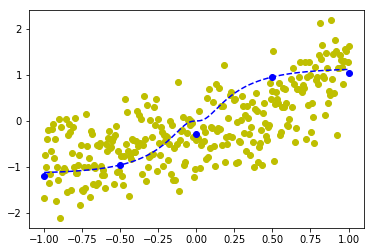

In [ ]:
net_reg_BFA = RobustNetwork(cost='MSE')
net_reg_BFA.AddLayer(Network.Layer(1))
net_reg_BFA.AddLayer(Network.Layer(10, act='arctan'))
net_reg_BFA.AddLayer(Network.Layer(1, act='identity'))

# Train the network
progress = net_reg_BFA.SGD(train[0], train[1], epochs=5000, lrate=1., batch_size=10, mode='BFA')

# Evaluate the cost 
print('Training cost = '+str(net_reg_BFA.Evaluate(train[0], train[1])))
print('    Test cost = '+str(net_reg_BFA.Evaluate(test[0], test[1])))

plt.plot(test[0],test[1],'yo')
plt.plot(train[0],train[1],'bo')

s = np.linspace(min(min(train[0]),min(test[0])),
                max(max(train[0]),max(test[0])), 200)

# original_net
reg_y = net_reg_BFA.FeedForward(np.array([s]).T)
plt.plot(s,reg_y,'b--')


### BDFA

In [ ]:
net_reg_BDFA = RobustNetwork(cost='MSE')
net_reg_BDFA.AddLayer(Network.Layer(1))
net_reg_BDFA.AddLayer(Network.Layer(10, act='arctan'))
net_reg_BDFA.AddLayer(Network.Layer(1, act='identity'))

# Train the network
progress = net_reg_BDFA.SGD(train[0], train[1], epochs=5000, lrate=1., batch_size=10, mode='BDFA')

# Evaluate the cost 
print('Training cost = '+str(net_reg_BDFA.Evaluate(train[0], train[1])))
print('    Test cost = '+str(net_reg_BDFA.Evaluate(test[0], test[1])))

plt.plot(test[0],test[1],'yo')
plt.plot(train[0],train[1],'bo')

s = np.linspace(min(min(train[0]),min(test[0])),
                max(max(train[0]),max(test[0])), 200)

# original_net
reg_y = net_reg_BDFA.FeedForward(np.array([s]).T)
plt.plot(s,reg_y,'b--')
